# Stirred (not shaken)

**MOD510 - Project 3 G05**   
- Parthasarathi Jena
- Jing Hou
- Hodjat Moradi  

Date: Nov.5.2023

In [1]:
# load libraries
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from numba import jit
from matplotlib import cm
#%matplotlib

## Abstract: 

This project allows us to investigate if it is possible to match with Computational Fluid Dynamics (CFD) simulation results by implementing simple approach of a series of N numbered mixing tanks Continuous- Stirred-Tank-Reactor (CSTR) model. The project was initiated with theoretical understanding of concentration equations and compare the mathematical equations solved by three different methods - Euler, Runge-Kutta second order (RK2) and Runge-Kutta fourth order (RK4). These three method's accuracy was investigate by comparing them with analytical solutions. It is evident that RK4 is the most accurate method among all with varied mixing tank number N = 1,2 and 3 while Euler method displays with higher scale of error in all scenarios. This can be clearly explained by the generated plots and the result is also matched with theoretical understanding of error scale as $\Delta t, \Delta t^2, \Delta t^4$ respectively with Euler, RK2 and RK4 methods. When searching for the optimal parameters of $N$ and $\tau$, least square and gradient descent optimization (learning rate = 0.001 is used) approaches have been applied [3]. Our CSTR model is fitted to two data scenarios - healthy aorta case and aorta with aneurysm case. The results from our CSTR model accurately reproduced the effluent concentration and it demonstrates the great fit of healthy aorta arch. However, aorta with aneurysm behaves differently, as it exhibit deviation to some degree from the CSTR model.

## Introduction:

In this project, we will implement ordinary differential equations (ODEs) models to compare with Computational Fluid Dynamics (CFD) simulations result[1]. The idea is to implement simple approach of Continuous- Stirred-Tank-Reactor (CSTR) model with n tanks in series [2] to reproduce and predict the effluent concentrations on aorta arch. Three different algorithms will be implemented- Euler, RK2 and RK4 and error scaling of these algorithms will be discussed. With the given CFD simulation data, we will investigate and look for the optimal value of $N$ and $\tau$ by using the our model. and Based on that, it is possible to obtain the crucial information about cardiac output- flooding rate (q) and volume of aortic arch (V). CSTR model also will be fit to two scenarios - healthy aorta and unhealthy aorta with aneurysm.

## Theory: 
The mathematical equations for n-tanks in a series follows from mass conservation 
([change of mass in the system]/time = [mass in]/time - [mass out]/time)


$$V_0\frac{dC_0}{dt} = q(C_{in}-C_0) \\

V_1\frac{dC_1}{dt} = q(C_0-C_1) \\
\\ \vdots\\
V_{n-1}\frac{dC_{n-1}}{dt} = q(C_{n-2}-C_{n-1})$$


In the above set of ODEs, $V_i$ is the volume of tank number i, $C_i = C_i(t)$ is the concentration in the tank at time t (unit mass/volume), $q$ is a constant volumetric injection flow rate (cardiac output and unit volume/time), and $C_{in} = C_{in}(t)$ is the injected concentration at time t.

Scaling of volumes.
In this project, we want to use n as a parameter without changing the total volume of the system, thus we want the $n = 1$ system to have the same
volume as, e.g., n = 10. We therefore need to scale the volumes of the individual tanks. To simplify, we shall assume that each tank has the same
volume V , hence the total volume is $$V_{Tot} = V_0 + V_1 + · · · + V_{n−1} = nV$$ which leads to $V = V_{Tot}/n$.


We can now rewrite the mass conservation equations as


$$\frac{dC_0}{dt} = \frac {n(C_{in}-C_0)}{\tau} \\
    \frac{dC_1}{dt} = \frac {n(C_0-C_1)}{\tau}  \\

   \\ \vdots\\
    \frac{dC_{n-1}}{dt} = \frac {(C_{n-2}-C_{n-1})}{\tau}$$

where $\tau \equiv V_{Tot}/q$. Note that $\tau$ has units of time. The **analytical solution** for $n = 1, 2, 3$ in a special case is given below


$$C_0(t) =  \exp\left(-\frac{t}{\tau}\right)\\
    C_1(t) = \frac{2t}{\tau}\exp\left(-\frac{2t}{\tau}\right) \\
    C_2(t) = \frac{9t^2}{2\tau^2}\exp\left(-\frac{3t}{\tau}\right)$$


### Exercise 1: Write your own ODE solver

**Part 1**. Implement an ODE solver, that solves an arbitrary (initial value) system of ODEs of the form


$$\frac {d\vec{y}}{dt} =  \vec{f}(\vec{y}, t)$$


where the solution $\vec{y}$ may be a vector. Since the equation system is completely generic, the solver has to take in as argument the function that computes the right hand side-vector; that is, you are not allowed to hard-code in a specific model. In addition, the solver needs to know the starting time, $t0$, the corresponding initial condition(s)$\vec{f}(\vec{y}, t)$, as well as the final simulation time, $t_f$. The user should be able to choose between the following methods:

1. Eulers method
2. Runge-Kutta second order (RK2)
3. Runge-Kutta fourth order (RK4)


$$
\frac {d}{dt}
\begin{pmatrix}
C_0\\ C_1\\ 
\vdots\\ 
C_{n-1}
\end{pmatrix}
=

\begin{pmatrix}
{f_1}(\vec{C}, t)\\
{f_2}(\vec{C}, t)\\
\vdots\\
{f_n}(\vec{C}, t)\\
\end{pmatrix}
$$



1. Eulers method:

$$  y_{n+1}= {y_{t}} +  f(y, t)\Delta t + \frac{1}{2!} y''(t)\Delta t^2 $$
$$  y_{n+1}= {y_{t}} +  f(y, t)\Delta t $$


2. Runge-Kutta second order (RK2)

$$k_1 = \Delta t \cdot f(y_n,t_n)$$
$$k_2 = \Delta t \cdot f(y_n + \frac {k_1}{2}, t_n + \frac {\Delta t}{2})$$
$$y_{n+1} = y_n + k_2 $$


3. Runge-Kutta fourth order (RK4)

$$k_1 = \Delta t \cdot f(y_n,t_n)$$
$$k_2 = \Delta t \cdot f(y_n + \frac {k_1}{2}, t_n + \frac {\Delta t}{2})$$
$$k_3 = \Delta t \cdot f(y_n + \frac {k_2}{2}, t_n + \frac {\Delta t}{2})$$
$$k_4 = \Delta t \cdot f(y_n + {k_3}, t_n + \Delta t )$$
$$y_{n+1} = y_n + \frac {1}{6}(k_1 + 2k_2 + 2k_3 + k_4) $$


In [2]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an equation of the form 
    d/dt(y) = f(y,t)
    this class takes a slope function, a method that calculates the step in value of y
    
    '''
    def __init__(self, slope_func, method ='rk4' ):
        '''
        initiates the ODE solver with a slope function and a step method 
        '''
        self.slope = slope_func
        self.set_method(method)
    
    def set_method(self, method):
        '''
        sets the method to calculate increment from y_i to y_(i+1)
        '''
        match method:
            case 'euler':
                self.increment = self.euler
            case 'rk2':
                self.increment = self.rk2
            case 'rk4':
                self.increment = self.rk4
            case other:
                print(f'{method} not implemented, choosing rk4 instead.')
                self.increment = self.rk4
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self,y,t,dt,*slope_pparams,**slope_nparams):
        '''
        This function takes y(t) and returns the values of 
        y(t+dt) using a specified method and slope function
        '''
        y_now=y
        step = self.increment(y_now, t, dt, *slope_pparams,**slope_nparams)
        y_next = y_now + step
        
        return(y_next)
    

In [3]:
class CSTRModel():
    '''
    This class makes a Continuous-Stirred-Tank-Reactor model 
    and provides methods to perform time domain simulations on it
    given model properties 
    '''
    
    def __init__(self, tau=2, N=1, timedata={}, c_init='empty',inj_prot=None):
        '''
        params:  make sure all the units are consistent
            tau : V/q time taken to inject one whole volume of the tank(s)
            N : number of subtanks the whole volume is divided into.
            timedata:
                the time data for simulation. this can be provided in two ways
                 1. a dictionary containing {'t_start, dt , t_end'}
                    t_start  : simulation start time 
                    dt: time diff between each simulation step
                    t_end  : simulation end time 
                 2. a list of simulation time stamps
            c_init : initial concentration of tracer in each spatial grid
                   : takes values {'first', 'empty', list }
                   : 'first' - case where first (0th) cell has a tracer conc
                   : 'empty' - case where the whole volume has 0 tracer conc
                   : list: list of tracer conc in each of the grid cell
            inj_protocol: injection protocol to use 
                   : takes values {'rect_1s', 'rect_2s', 'rect_3s', 
                                   'ramp_1s', 'ramp_2s', 'biphasic'}

        '''
        # set and initialize temporal parameters 
        self.make_time(timedata)
        
        # set and initialize spatial parameters 
        self.make_spatial( N, c_init)
        
        # injection protocol. cinj stores the concentration of injection 
        # create a list of concs being injected at each time step
        self.make_injection_protocol(inj_prot)
        
        # store model parameters
        self.tau = tau   # physical model parameter
        
    def make_injection_protocol(self, protocol):
        '''
        makes injection protocol
        '''
        self.inj_prot = protocol
        match protocol:
            case 'rect_1s':
                self.inj_t = [0,1.,1.,2.,3.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_2s':
                self.inj_t = [0,2.,2.,3.,4.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_3s':
                self.inj_t = [0,3.,3.,4.,5.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'ramp_1s':
                self.inj_t = [0,1.,1.,2.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'ramp_2s':
                self.inj_t = [0,2.,2.,3.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'biphasic':
                self.inj_t = [  0,1.0,1.,2.,2.,3.,3.,4.]
                self.inj_c = [0.7,0.7,0.,0 ,1 ,1 ,0 ,0 ]
            case None:
                self.inj_t = [0,1.]
                self.inj_c = [0, 0]
        
    def cinj(self, t):
        '''
        returns injection concentration at a given time
        '''
        return(np.interp(t,self.inj_t, self.inj_c))
        
    def make_spatial(self, N, c_init='empty'):
        # set initial condition of concs before sim starts
        self.N = int(N)  #number of mixing tanks in series
        match c_init: 
            case str():
                match c_init:
                    case 'first':
                        c_init = np.zeros(self.N)
                        c_init[0] = 1     # set the tracer concentration in first mixing tank to 1
                                          # conc in all other tanks is 0
                    case 'empty':
                        c_init = np.zeros(int(self.N)) # there are no trancer conc anywhere else
            case list() | np.ndarray():
                c_init = c_init   # set the initial concentrations of tanks if its provided. 
            case other:
                print('Node signature not recognized')
        self.c_init=c_init

    def make_time(self, timedata):
        '''
        set model time paramters
        '''
        match timedata:
            case list() | np.ndarray():
                #print(f'assigning time, its a list of l {len(timedata)}')
                self.ts = np.array(timedata)
                self.t_st, self.t_end = timedata[0], timedata[-1]
            case dict():
                self.t_st = timedata['t_start']
                self.t_end = timedata['t_end']
                dt = timedata['dt']
                self.ts = np.arange(self.t_st, self.t_end,dt)
                self.ts=np.append(self.ts, self.t_end)
                if dt > 0.1:
                    step = 0.1
                else: step = dt
                self.tsa = np.unique(np.sort(np.append(self.ts, np.arange(self.ts[0], self.ts[-1], step))))
                
            case other:
                print('Time signature not recognized')
        self.dts = self.ts[1:]- self.ts[:-1]
        
    def cstr(self, conc, ti,N=2,tau=2):
        '''
        this function provides the time derivative for the concentration 
        in a mixing tank at ti.
        CSTR time differencial
        f = d/dt(concentration) = slope = n/tau*(delta concentration)
            delta concentration in the equation above is the difference between 
            concentration in the nth tank and n-1th tank     
        input:
                conc : a numpy list of concentrat in n number of nodes at time step ti
                ti   : time at which the slope is being derived (note: in this model ti is not used)
                n    : number of tanks in series
                tau  : some parameter of the mixing tank (units = time)
                cinj : the concentration of the fluid being injected into the 0th mixing tank
                       at the ith time step.
        '''
        #print(ti, ts)
        #tau=self.tau
        #N=self.N
        #print(N)
        Cinj_t = self.cinj(ti) # injection concentration at ti
        c = np.append(Cinj_t, conc)  # we append the injection
        slope = N/tau*(c[:-1]-c[1:])
        #print('conc including injection:',c)
        return(slope)
    
    def time_sim(self, N, tau, c_init='empty', ODEmethod='rk4'): 
        '''
        Performs the time domain simulation on the model. 
        It is possible to change the model parameters N and tau at runtime
        returns the concentration c_out (concentration in the last tank.)
        
        '''
        # solution.append(list(self.y_0))
                
        # remake the grids
        self.make_spatial(N,c_init)
        self.tau=tau
        
        c_now = self.c_init    # set conc values to initial value
        #print('assigning c_init', c_now)
        c_out=c_now[-1:]      #save 
        
        slope_func=self.cstr
        s = ODEsolvers(slope_func=slope_func, method=ODEmethod)
        solver = s.solver
        nparams = {'N': self.N, 'tau':self.tau}
        for t,dt in zip(self.ts[:-1], self.dts):
            #print('conc matrix i m passing', c_now)
            c_next = solver(c_now, t, dt, **nparams)
            #print('slope matrix i m passing', step)
            #c_next = c_now+step
            c_out=np.append(c_out,c_next[-1])
            #solution.append(y_next)
            c_now= c_next
            #print(c_now)
        return c_out       
    
    def analytical(self, c0=1):
        '''
        Returns the analytical solution to a CSTR model
        the analytical solution is avaiable for max 3 cells
        the analytical solution is possible for 4 cells or higher
        '''
        tsa = self.tsa
        tau = self.tau
        match self.N:
            case 1:
                return c0*np.exp(-tsa/tau)
            case 2:
                return 2*c0*tsa/tau*np.exp(-2*tsa/tau)
            case 3:
                return c0*9*tsa*tsa/2/tau/tau*np.exp(-3*tsa/tau)
            case other:
                print('Not implemented')
                return(None)
            
    def props(self):
        '''
        this method is used for debugging
        returns the assigned attributes of the
        '''
        return [i for i in cls.__dict__.keys() if i[:1] != '_']
    
    def __repr__(self):
        out = f'CSTRModel(tau={self.tau}, N={self.N}, dt={self.dt}, Tmax={self.Tmax},c_init={self.c_init},inj_prot={self.inj_prot}))'
        return(out)
    
    def __str__(self):
        out = f'A CSTR model with {self.N} tanks and  residence time of {self.tau}s. \n'+\
        f'Simulation time:[0s to {self.Tmax}s with timesteps {self.dt}].\n'+\
        f'Initial concentration is {self.c_init} and injection protocol is {self.inj_prot}'
        return(out)    


**Part 2**.
1. Test you implementation against the analytical solutions in equation (3)
for $n = 1, 2 and 3$.
- for $n = 1$ use $\tau = 2, C_0(0) = 1$
- for $n = 2$ use $\tau = 2, C_0(0) = 1, C_1(0) = 0$
- for $n = 3$ use $\tau = 2, C_0(0) = 1, C_1(0) = C_2(0) = 0$

In [4]:
def comparision_plot(N, dt, ts, tsa, analytical, soln1, soln2, soln3):
    '''
    creates plots for of the time sim results 
    for various solver methods vs analytical soln
    '''
    # plt.clf()
    fig, axs=plt.subplots(nrows=2, figsize=(8,8))

    ax=axs[0]
    ax.plot(tsa , analytical, color='black', label='analytical')
    ax.plot(ts, soln1,'--*',markersize=5, label='euler', color='green',)
    ax.plot(ts, soln2,'--+',markersize=7, label='rk2', color='navy')
    ax.plot(ts, soln3,'--o',markersize=3, label='rk4', color='red')
    ax.set(xlabel='time ', ylabel='conc. at tank exit')
    ax.set(title = f'Tank/exit concentration,\n Number of tank:{N}, deltaT: {dt}')
    ax.legend()

    # Since the analytical solution has lots of points. find the indeces of f(x) with the same x from numerical and analytical solution to calculate the error
    indices = np.searchsorted(tsa, ts)
    
    ax=axs[1]
    ax.plot(ts[1:], np.abs(soln1[1:]-analytical[indices[1:]]), '-*', markersize=5, label='euler', color='green')
    ax.plot(ts[1:], np.abs(soln2[1:]-analytical[indices[1:]]), '-+', markersize=7, label='rk2', color='navy')
    ax.plot(ts[1:], np.abs(soln3[1:]-analytical[indices[1:]]), '-o', markersize=3, label='rk4', color='red')
    ax.set(xlabel='time ', ylabel='error', yscale='log')
    ax.set(title = f'Error,\n Number of tank: {N}, deltaT: {dt}')
    ax.legend()
    
    major_ticks = np.arange(ts[0], ts[-1] + 1, 1)
    for ax in axs:
        ax.set_xlim(ts[0]-0.5, ts[-1]+0.5)
        ax.tick_params(axis='x', which='both', direction='in', length=8)
        ax.set_xticks(major_ticks)
        ax.tick_params(axis='both', which='both', direction='in', length=3)
    
    plt.tight_layout()

In [5]:
def method_comparision(tau=2, N=1,dt=3,Tmax=20,c_init='first'):
    timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
    #nparams = model.nparams#
    methods = ['euler', 'rk2', 'rk4']
    soln = [0]*len(methods)
    for i, method in enumerate(methods):
        soln[i]=model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)
    
    #print(soln1,soln2,soln3)
    analytical = model.analytical()
    ts, tsa = model.ts, model.tsa
    comparision_plot(N, dt, ts, tsa, analytical, *soln)

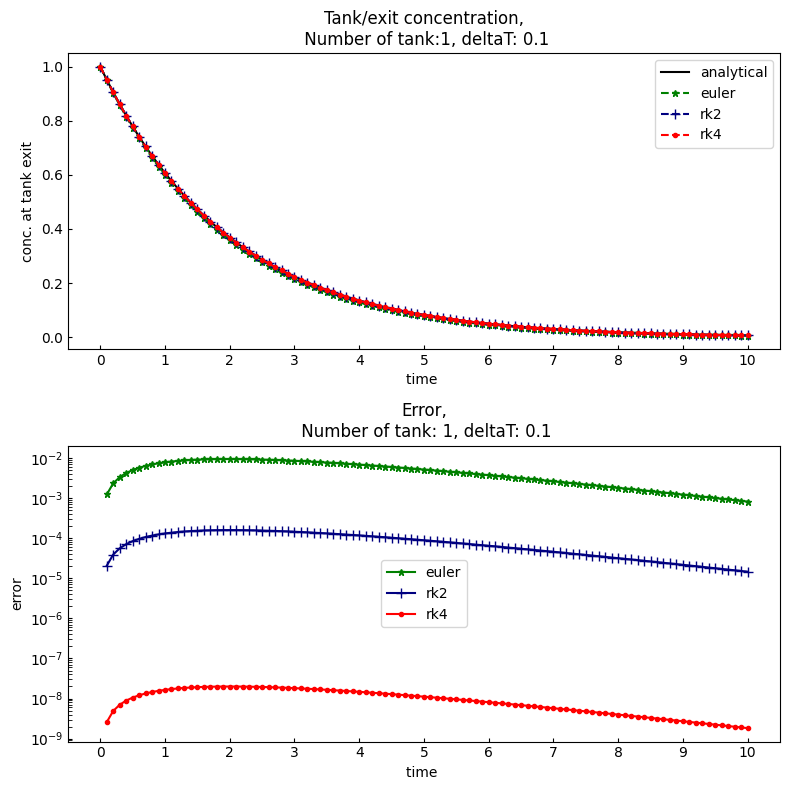

In [6]:
method_comparision(tau=2, N=1, dt=0.1, Tmax=10, c_init='first')

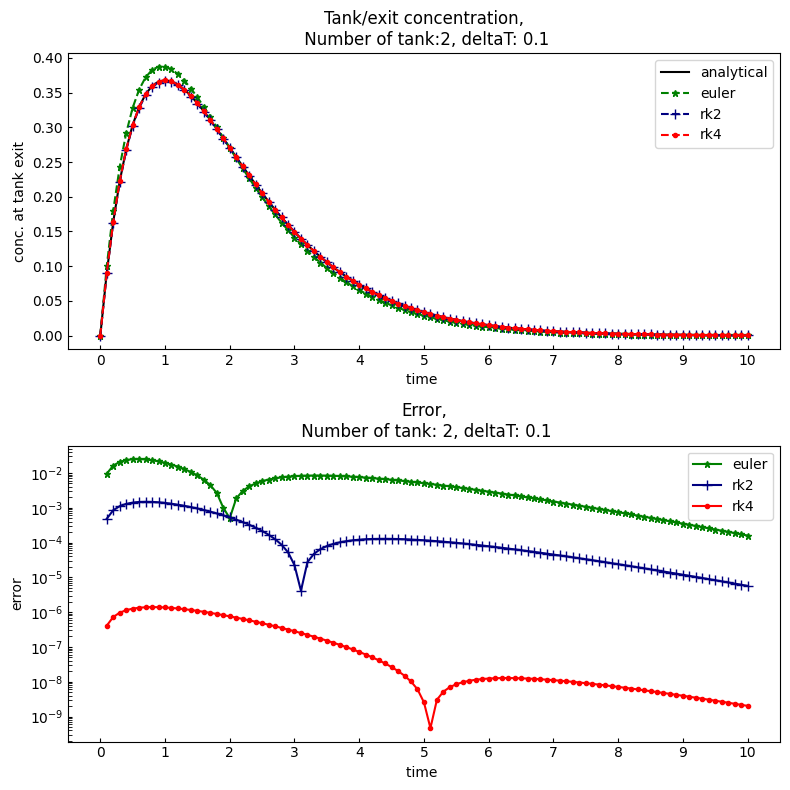

In [7]:
method_comparision(tau=2, N=2, dt=0.1, Tmax=10, c_init='first')

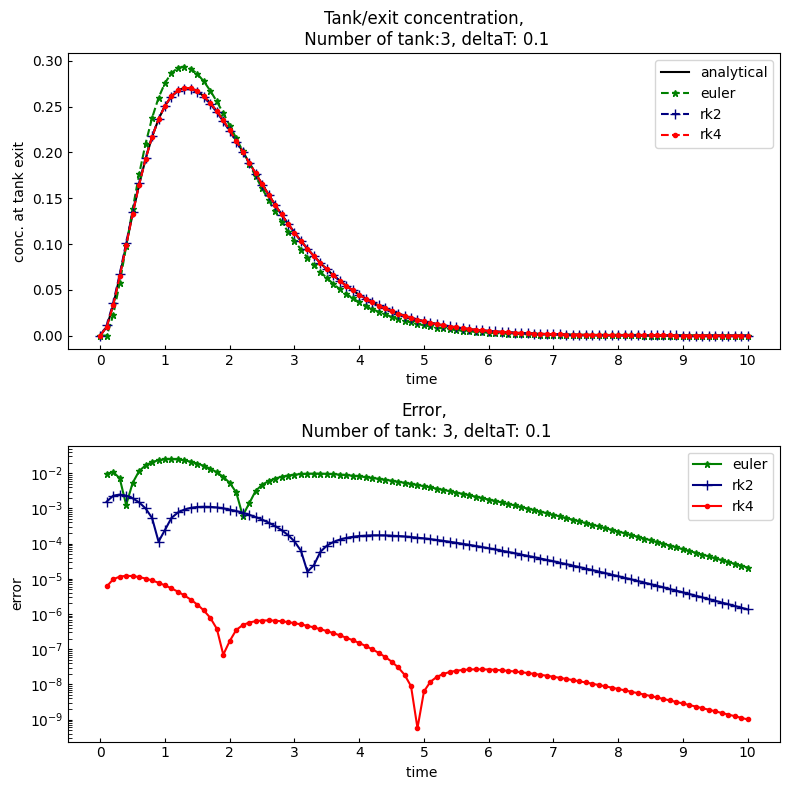

In [8]:
method_comparision(tau=2, N=3, dt=0.1, Tmax=10, c_init='first')

The implemetation is tested against the analytical solutions for all three setup with 1 to 3 tanks. In addition the error of each method is plotted. It is interesting to see how the error gets evolved in every time step. The change in analytical solutions curveture effects the error value. The error seems to be increasing while the curvuture is increasing and vice versa. At some point the numerival solution crosses the analetical one and the closest point in numerical solution shows the drop in error calculation.

The implementation is plotted against analytical solutions for all three setups, involving 1 to 3 tanks. Furthermore, the error for each method is graphically depicted, revealing the evolution of error at each time step. The alteration in the curvature of the analytical solutions directly impacts the error values, with error increasing as curvature increases and decreasing as curvature decreases. At a certain point, arround inflection point, the numerical solution intersects with the analytical one, resulting in the sharp error reduction.


**Part 3**.
 Pick $n =1, 2, or 3 $
 
1. plot the numerical error at t = 1, for the last tank, and for dt values in
the range $0.1, . . . 0.001$. (You may try lower values if you have a very fast
solver)
2. does the numerical error scale as expected for Euler, RK2, and RK4?

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]
1 euler -2.5515796685422756    1 rk2 -6.626188031738269    1 rk4 -15.609241179311667    
2 euler -1.6320657007019823    2 rk2 -4.277050475700403    2 rk4 -11.194801954179752    
3 euler -1.3901267713120724    3 rk2 -5.998799476283079    3 rk4 -9.628457566011932    


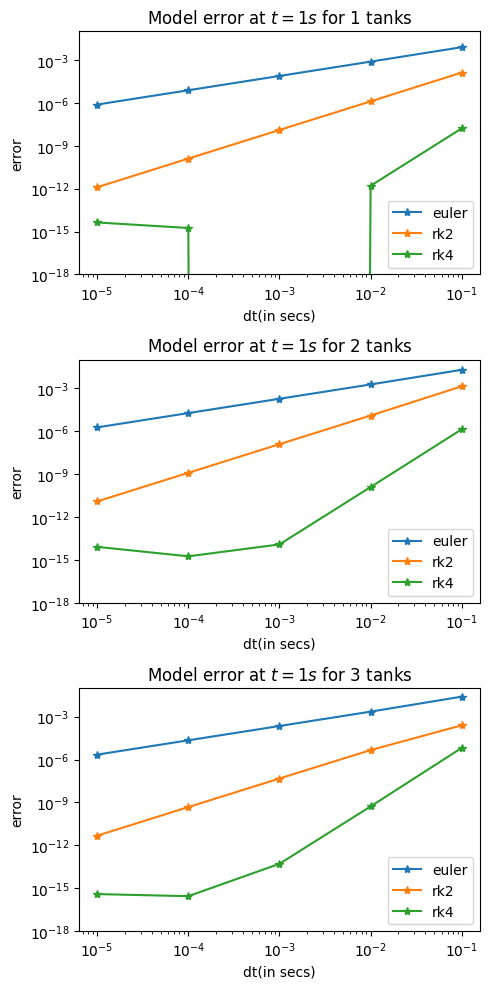

In [9]:
# parameters. do this for finer dt scaling
n = 5 # used to calculated 10**-n
tau = 2
Tmax = 1 # time at which the error is calculated
c_init = 'first'  # initial concs in the tanks

# time deltas
dts = np.geomspace(.1, 10**-n, n)
print(dts)

# make the figure
fig, axs = plt.subplots(nrows = 3, figsize=(5,10))
for N, ax in zip([1,2,3], axs):    
    for method in ['euler', 'rk2', 'rk4']:
        error = []
        for dt in dts:
            # make model
            timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
            model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
            
            # find numerical solution to and keep only the result at t= Tmax
            soln =model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)[-1]
            
            # find solution to and keep only the result at t= Tmax
            analytical = model.analytical()[-1]
            
            # find error
            error.append(np.abs(soln-analytical))
        err_slope=np.log((error[2]-error[0])/(dts[2]-dts[0]))
        print(N, method,err_slope,end ='    ')
        ax.plot(dts, error,'-*' ,label=method)

        # print(method,error)
    print()
    ax.set(xlabel='dt(in secs)', ylabel='error',
           title=f'Model error at $t=1s$ for {N} tanks',
           ylim=(10**-18,0.1),xscale='log', yscale='log')
    ax.legend()
plt.tight_layout()

The error scale of the numerical methods are as following:
- Euler method   : $O(dt)$
- Second-Order RK: $O(dt^2)$
- Forth-order RK : $O(dt^4)$

Initially, the errors scale very well, and the error decreases to a level of about $10^-15$. However, beyond this point, the effect of rounding errors becomes significant, and the error tends to stay around the level of the machine epsilon, which is approximately $10^{-15}$.
In the provided plots, it's evident that the error for the fourth-order Runge-Kutta (RK4) method reaches the level of $10^-15$. The complexity of the solution plays a crucial role in error behavior. More complex solutions exhibit higher curvature in the analytical solution, resulting in higher errors in the numerical solution. Consequently, in the three plots, the solution with one tank, being the simplest, shows lower numerical solution errors. As the time step (dt) decreases, the error reaches the $10^-15$ level faster, but the influence of rounding errors becomes apparent earlier.

For solutions with two and three tanks, the increased complexity leads to higher errors. As a result, the error level reaches 10^-15 later, reflecting the impact of the solution's intricacy on numerical accuracy.

It appears that something unusual is happening with the error behavior of the fourth-order Runge-Kutta (RK4) method in the problem with one tank. To investigate this, we conducted a detailed analysis by plotting the error for all time points of the RK4 solution across various time step values, including [0.1, 0.01, 0.001, 0.0001].

In [10]:
def error_comparision1(tau=2, N=1,dt=3,Tmax=20,c_init='first'):
    timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
    #nparams = model.nparams#

    soln=model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod='rk4')
    
    #print(soln1,soln2,soln3)
    analytical = model.analytical()
    ts, tsa = model.ts, model.tsa
    return ts, soln, analytical
    # comparision_plot(N, dt, ts, tsa, analytical, *soln)

In [11]:
N = 1
time1, soln1, an1 = error_comparision1(tau=2, N=N, dt=0.1, Tmax=8, c_init='first')
time2, soln2, an2 = error_comparision1(tau=2, N=N, dt=0.01, Tmax=8, c_init='first')
time3, soln3, an3 = error_comparision1(tau=2, N=N, dt=0.001, Tmax=8, c_init='first')
time4, soln4, an4 = error_comparision1(tau=2, N=N, dt=0.0001, Tmax=8, c_init='first')

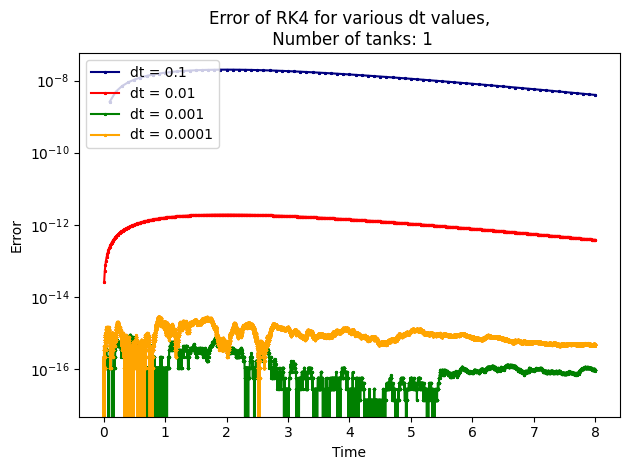

In [12]:
len(soln1)
len(an1)
plt.plot(time1[1:], np.abs(soln1[1:]-an1[1:]), '-*', markersize=2, label='dt = 0.1', color='navy')
plt.plot(time2[1:], np.abs(soln2[1:]-an2[1:]), '-*', markersize=2, label='dt = 0.01', color='red')
plt.plot(time3[1:], np.abs(soln3[1:]-an3[1:]), '-*', markersize=2, label='dt = 0.001', color='green')
plt.plot(time4[1:], np.abs(soln4[1:]-an4[1:]), '-*', markersize=2, label='dt = 0.0001', color='orange')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title(f'Error of RK4 for various dt values,\n Number of tanks: {N}')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

It appears that the numerical error in the RK4 method is indeed influenced by rounding errors, especially when it decreases to a very low level. As the time step (dt) becomes smaller and the numerical error approaches the order of machine epsilon (approximately $10^{-15}$), the effects of rounding errors become more prominent. Rounding errors are inherent to finite-precision arithmetic in computers and can limit the achievable numerical accuracy.

### Exercise 2: Fit CSTR model to CFD model: Healthy aorta

Steward-Hamilton equation [6]:

$$ q = \frac{M_{inj}}{\int_{0}^{\infty}C_{out}(t)dt}$$



**Part 1**.
1. Use $M_{inj}$ = 83.333 gram, equation (7) and the data in Healthy_rect_1s.csv
to show that q = 5 L/min.

only the injected mass tracer $M_{inj}$ is known. For the CFD simulations, $M_{inj} = 83.33$ grams is used. By knowing the mass of the injected tracer, and the outlet concentration, then we can calculate the volumetric injection flow rate $q$.

In [13]:
concdata = pd.read_csv('data/Healthy_rect_1s.csv')
dt = concdata.Time[1]-concdata.Time[0] # in seconds
dt =dt/60  # convert to mins
Minj = 83.333 #in grams
q = Minj/concdata.Concentration.sum()/dt   
(f'Flow rate from healthy heart data: {q:0.2f} ml/min or {q/1000:0.2f}L/min')

'Flow rate from healthy heart data: 5005.98 ml/min or 5.01L/min'

**Part 2**. Make Python functions that reproduces at least three other injection protocol than rect_1s (i.e. minimum four in total) from figure 5, as an
inspiration you can use the code below for the rect_1s

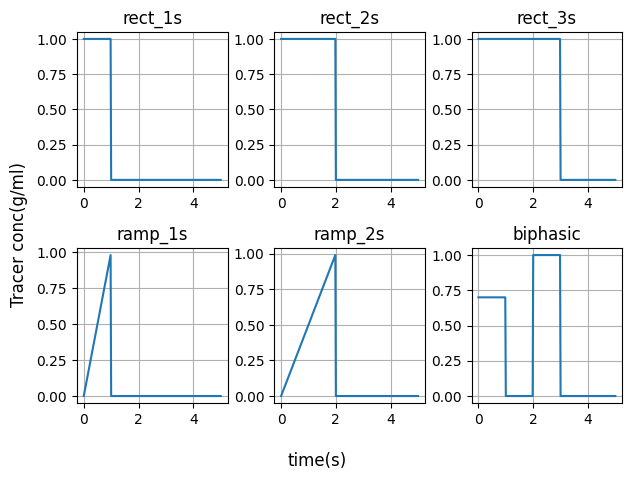

In [14]:
protocols = ['rect_1s', 'rect_2s', 'rect_3s', 'ramp_1s', 'ramp_2s', 'biphasic']
t = concdata.Time.to_numpy()
Tmax = t.max()
dt = 0.02
fig, axs = plt.subplots(nrows = 2, ncols = 3)
axs = axs.flatten()
for ax, protocol in zip(axs, protocols):
    #timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(timedata=t, inj_prot=protocol)
    c = model.cinj(t)  # injection concentrations
    ax.plot(t,c)
    ax.grid()
    ax.set_title(protocol)
fig.supylabel('Tracer conc(g/ml)')
fig.supxlabel('time(s)')
plt.tight_layout()

The protocols are defined in the function **make_injection_protocol()** in the python class **CSTRModel()**. The codes above extracts the injection protocols from the class and plots them.

**Part 3**.
- For the 1s rectangular pulse injection protocol, tune $\tau = Vtot/q$ and the number of compartments to match the data for the healthy patient (Healthy_rect_1s.csv) .
- Make a figure where you show your "best match". Use scatter points for the data, and solid lines for your simulation.
- "Best match" of VTot can be done by one of the following methods, there will be an increasing number of points given if you choose the most difficult
method
1. (easy) manually adjust V to match data
2. (moderate) use scipy.optimize.curve_fit to find V
3. (hard) In the course we have covered several algorithms that are useful for finding roots and/or minima of functions, e.g., fixed point iteration,
Newton’s Raphson’s method, the bisection method, the secant method, and gradient descent. Implement one of these methods, and use it to find the $\tau$ -value that minimizes SSR (see Appendix A). Hint: Depending on the method(s) you choose, you may have to implement a Python function to calculate the second derivative of C2 with respect to $\tau$.

In [15]:
def load_CFD_data(healthy=True, protocol = 'rect_1s'):
    '''
    Loads theCFD data to a dataframe
    '''
    if healthy: h = 'Healthy'
    else: h = 'Aneurysm'
        
    datafile = f'data/{h}_{protocol}.csv'
    print(datafile)
    concdata = pd.read_csv(datafile)
    t = concdata.Time.to_numpy()
    conc_CFD = concdata.Concentration.to_numpy()
    return(t,conc_CFD)

In [16]:
def plot_SSR_Surface(t,conc_CFD,taus=np.arange(2.,3.,0.1),Ns= np.arange(45,53,1),\
                      levels = np.arange(0,1,0.1)):
    x = taus # tau
    y =  Ns # N
    #t,conc_CFD=load_CFD_data(healthy=healthy, protocol=protocol)
    print(f'N:{len(y)}  taus:{len(x)}')
    X,Y = np.meshgrid(x, y) # grid of point
    Z=[]
    for x,y in (zip(X,Y)):
        z=[]
        for tau,N in (zip(x,y)):
            #print(_)
            z.append(SSR(tau= tau,N=N,xdata=t, ydata = conc_CFD))
        Z.append(z)
    Z=np.array(Z)
    idx=np.where(Z==Z.min())
    print(f'min error: {Z.min()}')
    print(f'parameters: {X[idx]}{Y[idx]}')

    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection = '3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
    plt.figure()
    cset = plt.contour(X,Y,Z,levels = levels, linewidths=2,cmap=cm.Set2)
    #cset=contour(X,Y,Z)
    plt.clabel(cset,inline=True,fmt='%.5f',fontsize=10)
    plt.scatter(X[idx],Y[idx], label='minima')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    #colorbar(im) # adding the colobar on the right
    plt.title('Contour')
    a = plt.legend()

In [17]:
class Minimizer():
    '''
    provides various minimization tools
    '''
    def __init__(self, prec=1e-8,MAXIT=10):
        self.prec=prec
        self.MAXIT=MAXIT
        
    def gradient(self, f,x, dx=10e-4,**kwarg):
        '''
        takes a function f and returns its gradient(df/dx) at x
        using central difference, 
        '''
        return (f(x+dx,**kwarg)-f(x-dx,**kwarg))/2/dx
    
    def curvature(self, f,x,dx=10e-4,**kwarg):
        '''
        takes a function f and returns its curvature (d**2f/dx**2) at x
        using central difference, 
        '''
        curvature = (f(x+dx,**kwarg)-2*f(x,**kwarg)+f(x-dx, **kwarg))/2/dx
        
    def gradient_descent(self, f,x,df, g=.001, **kwarg):
        '''Minimize f(x) by gradient descent.
        f   : min(f(x))
        x   : starting point 
        df  : derivative of f(x)
        g   : learning rate
        prec: desired precision

        Returns x when it is closer than eps to the root, 
        unless MAXIT are not exceeded
        '''
        x_old = x
        df_old=df(f,x_old,**kwarg)
        for n in range(self.MAXIT):
            #plot_regression_line(x_old)  
            x_new = x_old - g*df_old
            if(np.max(np.abs(x_new-x_old))<self.prec):
                print('Found solution:', x_new, 
                      ', after:', n, 'iterations.' )
                return x_new
            x_old=x_new
            df_old=df(f,x_old,**kwarg)

        print('Max number of iterations: ', self.MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', x_guess:=f(x_new))
        return x_new,np.array(x_guess)

    def Jacobian(self,f,x,dx=1e-5,**kwarg):
        N=len(x)
        f0=f(x,**kwarg)
        #print('in jacobian f0=f(x,**kwarg)')
        J=np.zeros(shape=(N,N))
        #print(J,f0)
        for j in range(N):
            x[j] = x[j] +  dx
            fx=f(x,**kwarg)
            for i in range(N):   
                J[i][j] = (fx[i]-f0[i])/dx
                #print(f'assigning J{i},{j}')
            x[j] = x[j] -  dx
        return J

    def newton_raphson(self, f,x,J=None, jacobian=False,**kwarg):
        '''Approximate solution of f(x)=0 by Newtons method.
        The derivative of the function is calculated numerically
        f   : f(x)=0.this is the derivative
        J   : Jacobian
        x   : starting point  
        eps : desired precision

        Returns x when it is closer than eps to the root, 
        unless MAX_ITERATIONS are not exceeded
        '''
        MAX_ITERATIONS=self.MAXIT
        #x=args
        self.n_iter = 0 
        x_old = np.copy(x)
        for n in range(MAX_ITERATIONS):
            #plot_regression_line(x_old) 
            self.n_iter = n
            if not jacobian:
                #print('call Jac with',x_old)
                J_=self.Jacobian(f,x_old,**kwarg)
            else:
                J_=J(x_old)
            z=np.linalg.solve(J_,-f(x_old,**kwarg))
            x_new=x_old+z
            if(np.sum(abs(x_new-x_old))<self.prec):
                #print('Found solution:', x_new, 
                #      ', after:', n, 'iterations.' )
                return x_new
            x_old=np.copy(x_new)
        print('Max number of iterations: ', self.MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', f(x_new))
        return x_new

In [18]:
def SSR(tau, xdata=[], ydata=[], N=1, inj_prot=protocol):
    '''
    Returns the sum of squared residuals
    params:
        N, tau and inj_prot(injection protocol) : model parameters
        xdata is the time data
        ydata is the curve we need to fit to
    returns the SSR
    '''
    timedata = xdata
    conc_CFD = ydata
    model = CSTRModel(tau=tau, N=N, timedata=timedata, inj_prot=inj_prot)
    conc_out = model.time_sim(N, tau)
    #print (f'conc_CFD: {len(conc_CFD)}, conc_out: {len(conc_out)}')
    SSR = np.sum((conc_CFD-conc_out)**2)
    return SSR

def dSSR(tau,**kwarg):
    '''
    returns the slope of the SSR function at the tau using 
    central diff from our minimizer
    params:
        tau : model parameter (residence time)
    returns 
        slope of SSR
    '''
    a = Minimizer()
    gradient = a.gradient
    return (np.array([gradient(SSR, tau,**kwarg)]))

def ddSSR(tau,**kwarg):
    '''
    returns the curvature of the SSR function at the tau using 
    central diff from our minimizer
    params:
        tau : model parameter (residence time)
    returns 
        curvature of SSR at tau
    '''
    a = Minimizer()
    gradient = a.gradient
    return (np.array([gradient(dSSR, tau,**kwarg)]))

In [19]:
def fit_CFD_data(healthy=True, protocol='rect_1s', Ns=range(47, 52), solver='NR'):
    '''
    does the following things:
       1. reads CFD simulated data
       2. cycles through various number of compartments and finds optimal 
          tau at each N. 
     '''

    t, conc_CFD = load_CFD_data(healthy, protocol)  # reads CFD data
    leastSSR = 200_000  # set value of SSR to some ridiculous value
    m = Minimizer()
    df = pd.DataFrame(data = {'Number of compartments': Ns, 'Tau':None, 'SSR':None}).set_index('Number of compartments')

    for N in Ns:
        params = {'xdata': t, 'ydata': conc_CFD, 'N': N, 'inj_prot': protocol}
        tau = 2.  # first guess
        if solver == 'graddesc':
            df.loc[N, 'Tau'] = m.gradient_descent(
                f=SSR, x=tau, df=dSSR, MAXIT=10000, **params)
        else:
            # newton raphson implimentation takes a list and returns a list
            # so the input requires to be sent as a list.
            df.loc[N, 'Tau'] = m.newton_raphson(
                x=[tau], f=dSSR, jacobian=False, **params)[0]
        df.loc[N, 'SSR'] = SSR(tau=df.loc[N, 'Tau'], **params)
        print(f"Progress: {N/Ns[-1] * 100:.1f}%", end='\r', flush=True)
        # if ssr < leastSSR:
        #     optimal_N = N
        #     optimal_tau = tau_
        #     print(f'new optimal tau found {optimal_tau:0.4f}s, >N= {optimal_N}, SSR: {ssr}')
        #     leastSSR = ssr
        '''
        #uncomment this part if you want the loop to stop once SSR starts incereasing with N
        else:
            print(
                f'Minima found at N={optimal_N} tanks and τ ={optimal_tau:.4f},',
                f' using {solver} in {m.n_iter} iterations(avg)')
            print('-'*80)
            break
        '''    
    return df

data/Healthy_rect_1s.csv
N:50  taus:15
min error: 17.89164072863964
parameters: [2.7][50]


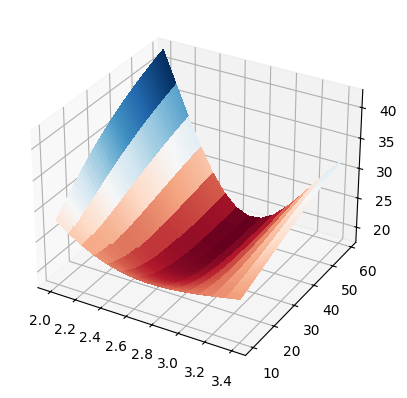

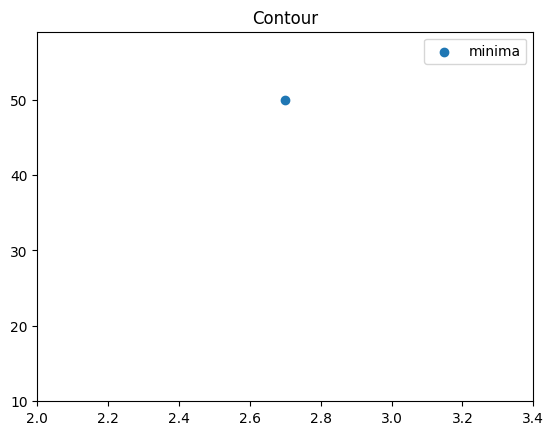

In [20]:
t, conc_CFD = load_CFD_data(healthy=True, protocol='rect_1s')
plot_SSR_Surface(t,conc_CFD,Ns=np.arange(10,60,1),taus=np.arange(2,3.5,0.1),levels=np.arange(11,15,0.2))

The simulated results matched to the provided healthy responces for **all** the injection protocols CFR responses. The parameters, number os mixing compartments, $\tau$ and minimum values are stored in the **sim_results** dictionary for later use.

In [21]:
sim_results ={}
for protocol in protocols:
    # fig, ax = plt.subplots()
    sim_results[protocol] = fit_CFD_data(
            healthy=True, protocol=protocol, Ns=range(20, 60), solver='NR')

data/Healthy_rect_1s.csv
data/Healthy_rect_2s.csv
data/Healthy_rect_3s.csv
data/Healthy_ramp_1s.csv
data/Healthy_ramp_2s.csv
data/Healthy_biphasic.csv


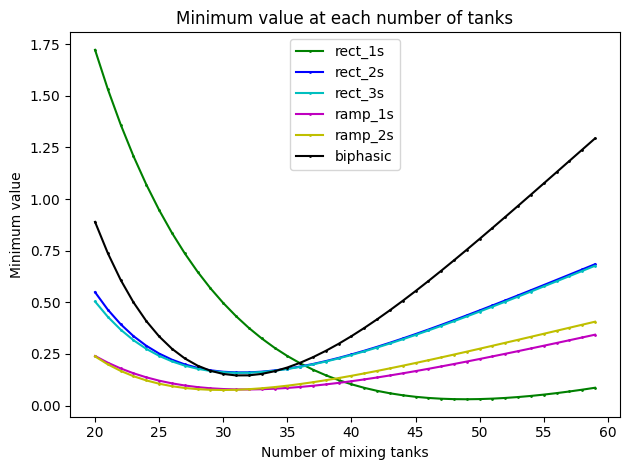

In [22]:
fig, ax = plt.subplots()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
col = 0
for protocol, result in sim_results.items():
    # print(sim_results[protocol])
    col += 1
    ax.plot(result.index, result['SSR'], '-o', color =colors[col],
            markersize=1, label=protocol,)
ax.set_title(f'Minimum value at each number of tanks')
ax.set_xlabel(f'Number of mixing tanks')
ax.set_ylabel(f'Minimum value')
#handles = ax.get_legend_handles_labels()
ax.legend()  # (*handles,loc='lower right', ncol=5)
# plt.grid()
plt.tight_layout()

Using Newton-Raphson's method, minimum points are found trying to fit the model to all injection protocols provided responses. Most of the lowes minima located arround 30 compartments. The **rect_1s** lowest minima however seems to be colse to 50 compartments.  
The function below extracts the parameters associated with lowest minima for every injection protocol:

In [23]:
def extract_optimum_params(sr = sim_results):
    '''
    find the fit parameters from lowest minima
    Takes the simulation result dictionary and returns the fit parameters in a dataframe, df
    '''
    df = pd.DataFrame(columns=['Number of compartments', 'Tau', 'SSR'] )
    for protocol, result in sr.items():
        lowest_min = result['SSR'].min()
        row_of_min = result[result['SSR'] == lowest_min].reset_index()
        df.loc[protocol] = row_of_min.iloc[0]

    return df

In [24]:
opt_params = extract_optimum_params(sim_results)
opt_params.index.name = 'Injection protocols'
opt_params

,Number of compartments,Tau,SSR
Injection protocols,,,
rect_1s,49,2.367106,0.030296
rect_2s,31,2.392633,0.160266
rect_3s,31,2.393847,0.158292
ramp_1s,32,2.356883,0.0777
ramp_2s,30,2.381092,0.075135
biphasic,31,2.353443,0.145808


Lets compare the result with optimised parameters:

In [25]:
def compare_plot(protocols=protocols, opt_params=opt_params, forcast=False, forcast_protocol= 'rect_1s', healthy=True):
    '''
    The function dose 2 jobs.
    if forcast = False: Then compares the the original responses with the fitted ones for the protocols.
        Use for check fit quality
        
    if forcast = True: Then plots all the responces by only using the forcast protocol fit parameters.
        Use to see the forcast of specific protocol on selected protocols.
        
    The plots arrangment automaticaly fitts to number of plots
    '''
    nplots = len(protocols)
    ncol = min(nplots, 3)
    nrow = (nplots - 1) // ncol + 1
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, sharex='col', sharey='row', figsize=(10, 7.5))
    if nplots>1: axs = axs.ravel()
    else: axs = [axs]
    # extract the fit parameters of the protocol used for forcasting
    N=opt_params.loc[forcast_protocol, 'Number of compartments']
    tau=opt_params.loc[forcast_protocol, 'Tau']

    for ax, protocol in zip(axs, protocols):
        if not forcast:
            # optimum parameters for the specific injection protocol
            N=opt_params.loc[protocol, 'Number of compartments']
            tau=opt_params.loc[protocol, 'Tau']

        t, conc_CFD = load_CFD_data(healthy=healthy, protocol=protocol)
        
        model = CSTRModel(timedata=t, inj_prot=protocol)
        fitted_model = model.time_sim(N=N, tau=tau)
        injection = model.cinj(t)
        
        ax.plot(model.ts, fitted_model, 'o', color ='b',
        markersize=1, label='numerical')
        ax.plot(model.ts, injection, '--', markersize=2,
        label='injection', alpha=0.5, lw=1)
        ax.plot(t, conc_CFD, label='CFD', color= 'r')
        ax.set_title(f' {protocol}')
        ax.set_xlabel(f'Simulation time(s)')
        ax.set_ylabel(f'Concentration at exit $Cout$ (s)')
        ax.legend()
        # plt.grid()
    fig.suptitle('Fitting CSTR model to the heart data', fontsize=14)
    plt.tight_layout()


data/Healthy_rect_1s.csv
data/Healthy_rect_2s.csv
data/Healthy_rect_3s.csv
data/Healthy_ramp_1s.csv
data/Healthy_ramp_2s.csv
data/Healthy_biphasic.csv


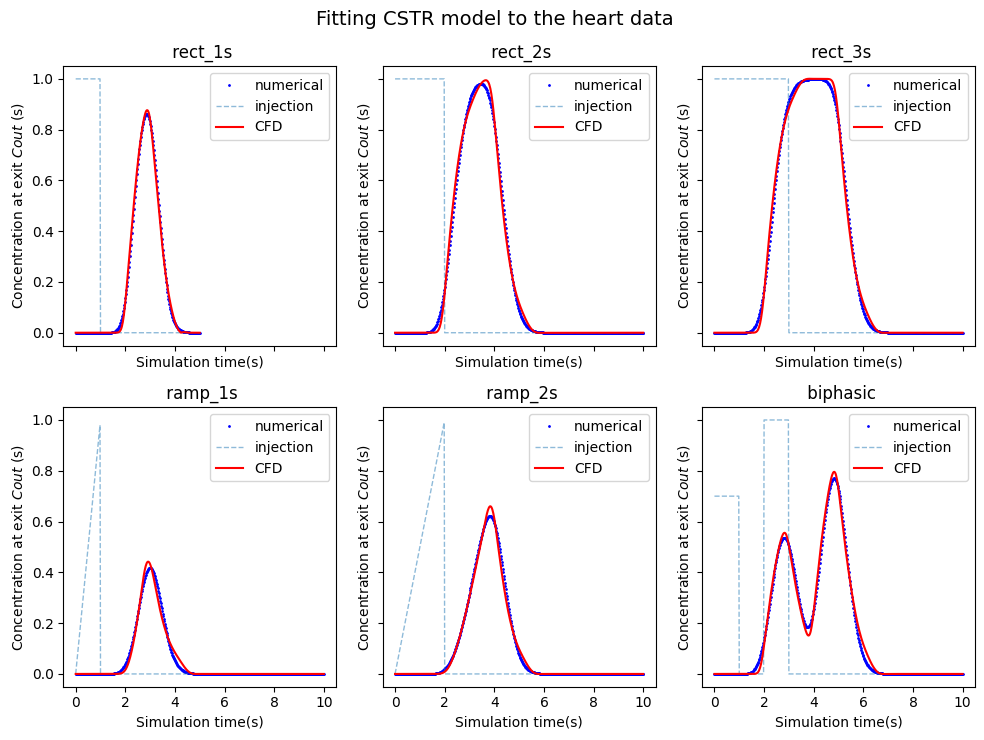

In [26]:
compare_plot(protocols=protocols[0:8], forcast=False)

The above plots compare the responses simulated with fitted parameters roe every injection protocol to the CFD data for healthy one.

**Part 4**
- Choose at least three other injection protocol than rect_1s from figure 5, use the model you ended up with in part 3 to predict what will happen.
- Illustrate your forecasts with one or more figures where you compare model to data.
- Discuss your findings.


data/Healthy_rect_1s.csv
data/Healthy_rect_2s.csv
data/Healthy_rect_3s.csv
data/Healthy_ramp_1s.csv
data/Healthy_ramp_2s.csv
data/Healthy_biphasic.csv


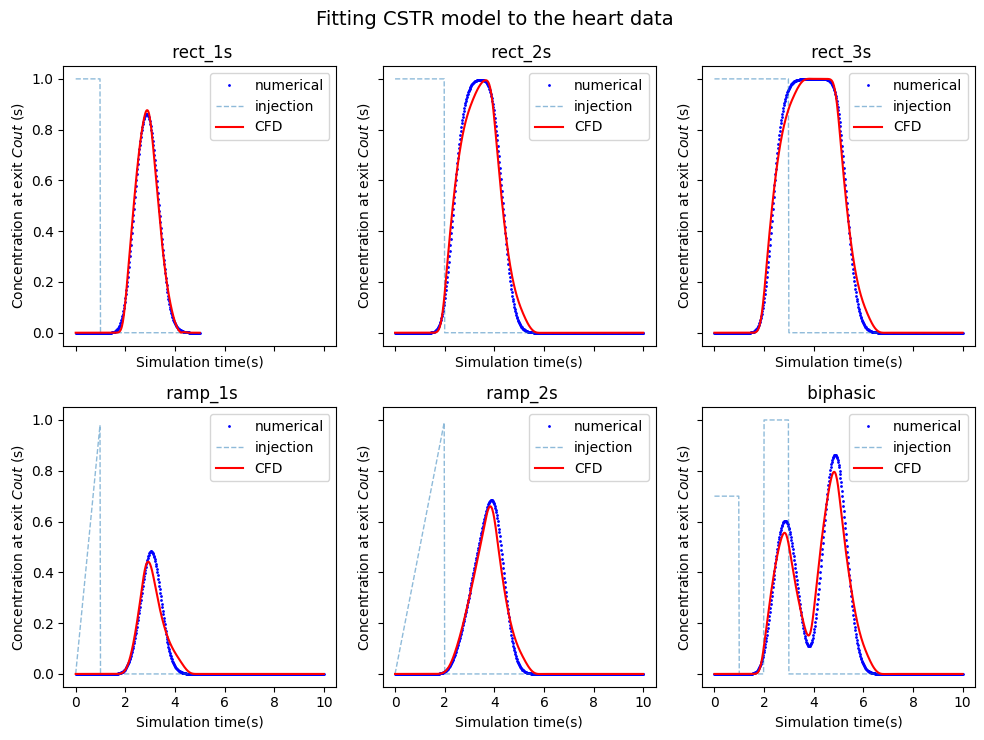

In [27]:
compare_plot(protocols=protocols[0:8], forcast=True, forcast_protocol='rect_1s')

fit parameters to 'rect_1s' is used to plot the model response to all the injection protocols and the result are ploted above. By changing the forcast_protocol in the compare_plot function to other protocols, the fit parameters calculated for the choosen forcast protocol will be used to generate the same type of plots shown above.
It seems that the model fit to rect_1s has hard time to predict the sharp turns in the CFD data. Changing the forcast protocol to any other protocol improves the all the forcasts but rect_1s:

data/Healthy_rect_1s.csv
data/Healthy_rect_2s.csv
data/Healthy_rect_3s.csv
data/Healthy_ramp_1s.csv
data/Healthy_ramp_2s.csv
data/Healthy_biphasic.csv


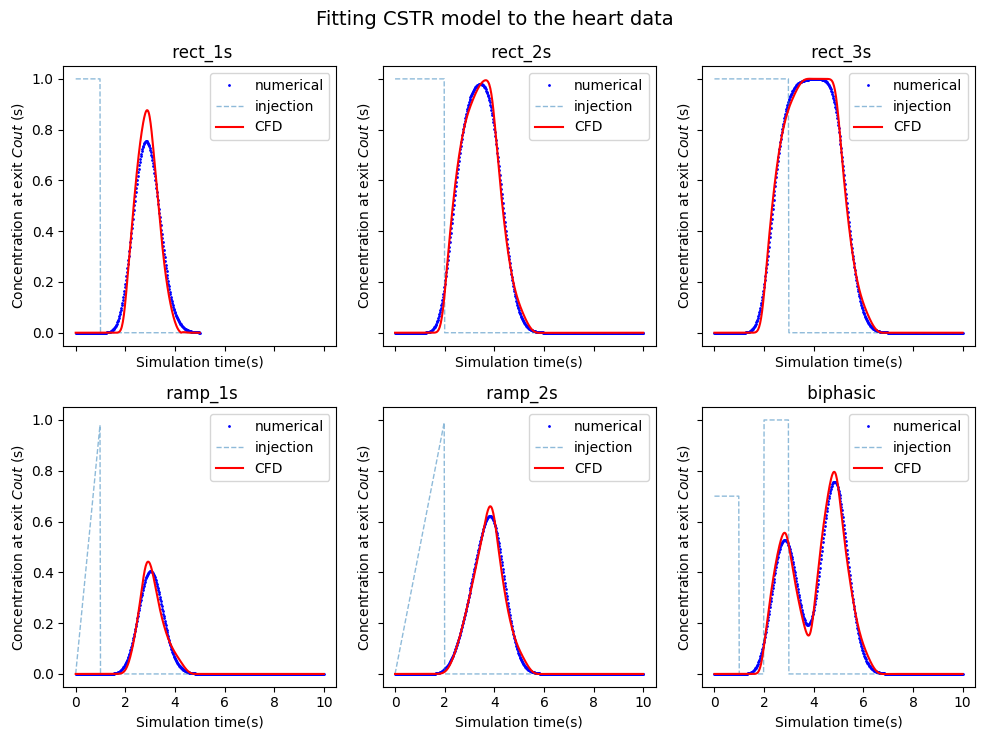

In [28]:
compare_plot(protocols=protocols[0:8], forcast=True, forcast_protocol='ramp_2s')

Above forecast plots are using ramp_2s as forcast protocol.
We know from the opt_params table above that the optimum $\tau$ value are close to eachother for all protocols. In the other hand optimum number of tanks calculated are very close for all the protocols but rect_1s. That could be the reason that the forcast used by any other protocol that rect_1s is a good fit to all but rect_1s protocol response, and rect_1s fit parameters give poorer fit to other protocols responses.

### Exercise 3:  Fit CSTR model to CFD model: Aorta with aneurysm

**Part 1**.
- Repeat exercise 2, part 3 for the case of the unhealthy patient with an aneurysm. Note: you have to find new values for n and VTot. The relevant data is found in the text file Aneurysm_rect_1s.csv.



data/Aneurysm_rect_1s.csv
N:40  taus:15
min error: 11.33046607244679
parameters: [2.8][43]


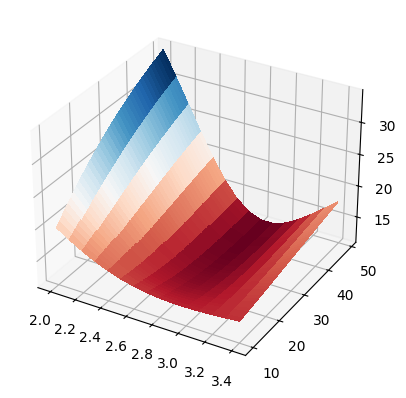

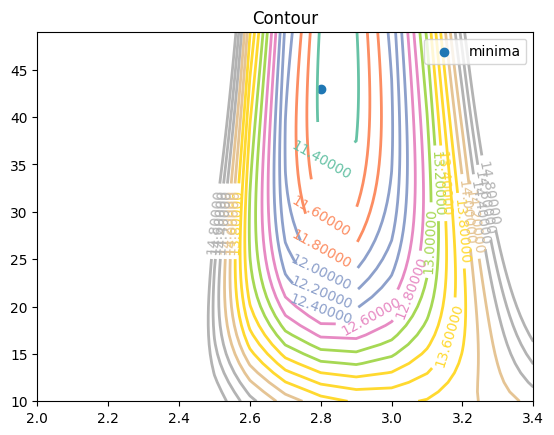

In [29]:
t, conc_CFD = load_CFD_data(healthy=False, protocol='rect_1s')
plot_SSR_Surface(t,conc_CFD,Ns=np.arange(10,50,1),taus=np.arange(2,3.5,0.1),levels=np.arange(11,15,0.2))

In [30]:
protocol = 'rect_1s'
sim_results_unhealthy ={}
sim_results_unhealthy[protocol] = fit_CFD_data(
            healthy=False, protocol=protocol, Ns=range(10, 40), solver='NR')

data/Aneurysm_rect_1s.csv


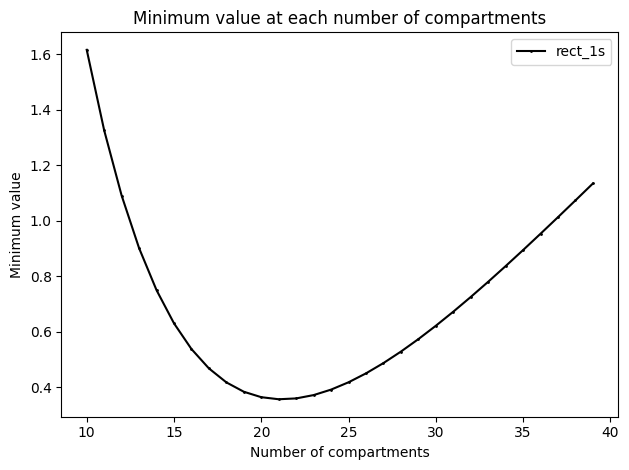

In [31]:
result = sim_results_unhealthy['rect_1s']
fig, ax = plt.subplots()
ax.plot(result.index, result['SSR'], '-o', color =colors[col],
            markersize=1, label=protocol,)
ax.set_title(f'Minimum value at each number of compartments')
ax.set_xlabel(f'Number of compartments')
ax.set_ylabel(f'Minimum value')
#handles = ax.get_legend_handles_labels()
ax.legend()  # (*handles,loc='lower right', ncol=5)
# plt.grid()
plt.tight_layout()

In [32]:
opt_params_unhealthy = extract_optimum_params(sim_results_unhealthy)
opt_params_unhealthy

,Number of compartments,Tau,SSR
rect_1s,21,2.456184,0.355893


data/Aneurysm_rect_1s.csv


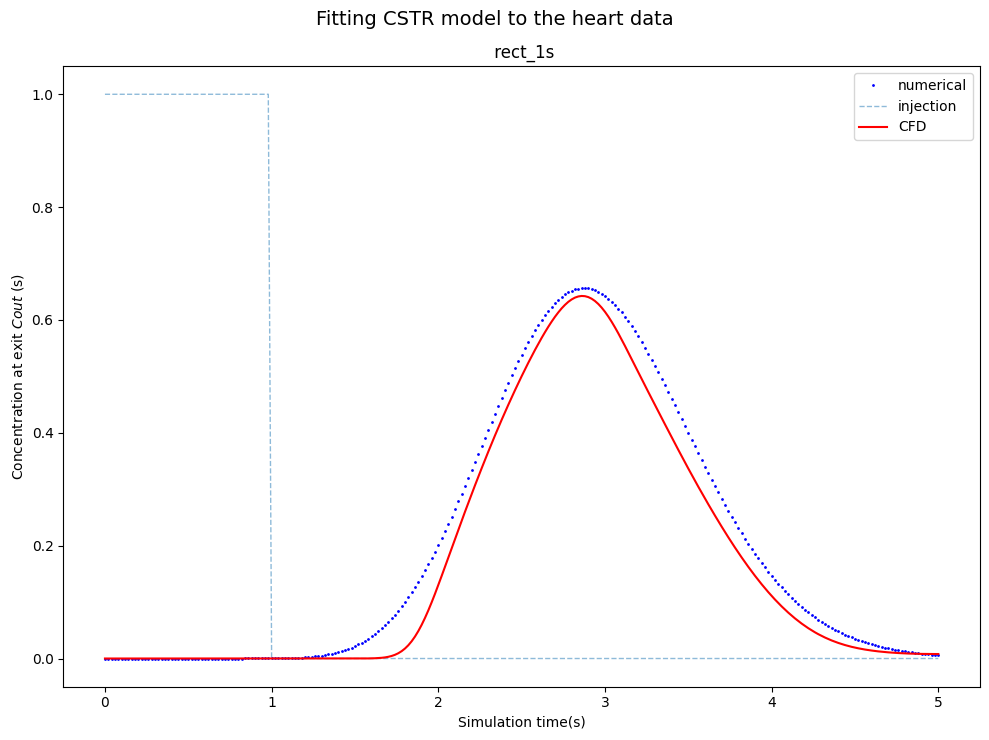

In [33]:
compare_plot(protocols=[protocol], opt_params=opt_params_unhealthy, forcast=False, healthy=False)

**Part 2.**
- Similarly, repeat exercise 2, part 4 for the case with an aneurysm.

data/Aneurysm_rect_1s.csv
data/Aneurysm_rect_2s.csv
data/Aneurysm_rect_3s.csv
data/Aneurysm_ramp_1s.csv
data/Aneurysm_ramp_2s.csv
data/Aneurysm_biphasic.csv


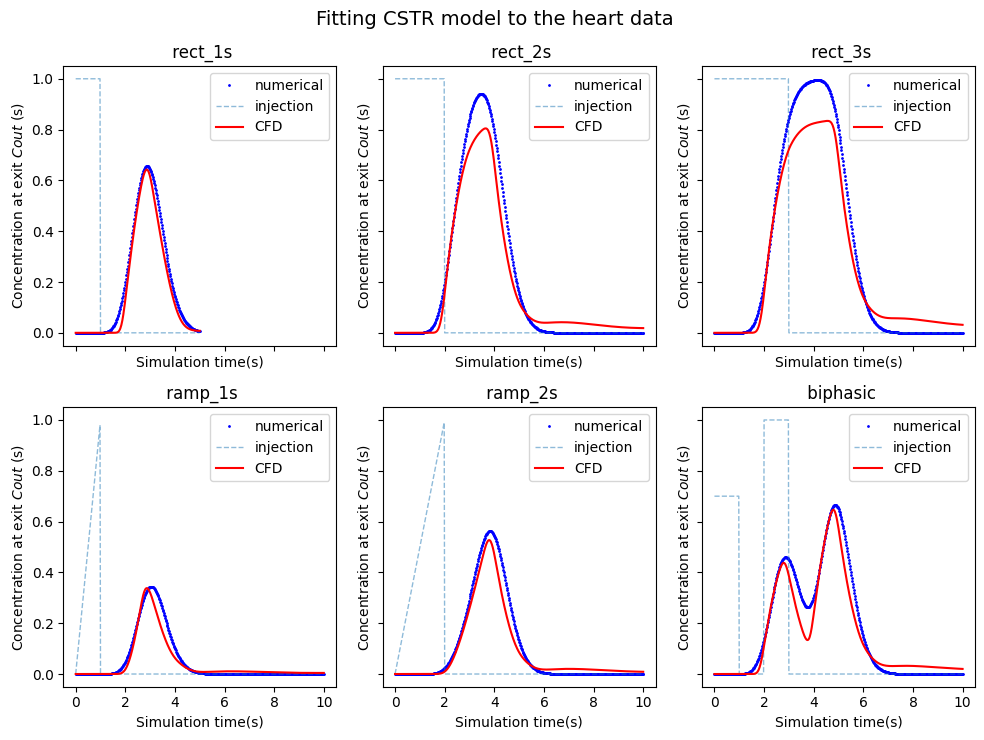

In [34]:
compare_plot(protocols=protocols, 
             opt_params=opt_params_unhealthy, 
             forcast=True, healthy=False, 
             forcast_protocol='rect_1s')


**Part 3.**
- Compare the number of compartments you ended up with in the two cases (healthy vs. aneurysm). Was it very different, why / why not?

In [35]:
print(f"The number of compartments for healthy aorta is {opt_params.loc['rect_1s', 'Number of compartments']}")
print(f"The number of compartments for aorta with aneurysm is {opt_params_unhealthy.loc['rect_1s', 'Number of compartments']}")

The number of compartments for healthy aorta is 49
The number of compartments for aorta with aneurysm is 21


The number of compartments for unhealthy aorta is lower than healthy one.


**Part 4.**
- Discuss strengths and weaknesses of the CSTR approach. What have you learned from this exercise?

------------------------------------
### **Reflections**:

Partha:

Jing:


Hodjat:


### **Conclusion**: 




### **References**: 
[1] John David Anderson and John Wendt. Computational Fluid Dynamics, volume 206. Springer, 1995.  
[2] H. Scott Fogler and Scott H. Fogler. Elements of Chemical Reaction Engineering. Pearson Educacion, 5 edition, 2020.  
[3] Aksel Hiorth. Modeling and Computational Engineering. https://github.com/ahiorth/CompEngineering, 2022.  
[4] 
